In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import odeint, solve_ivp
import matplotlib.animation as animation


# 2-Body Orbit
Using the Lagrangian $L=\frac{G \text{m1} \text{m2}}{\sqrt{(\text{x2}(t)-\text{x1}(t))^2+(\text{y2}(t)-\text{y1}(t))^2}}+\frac{1}{2} \text{m1} \left(\text{x1}'(t)^2+\text{y1}'(t)^2\right)+\frac{1}{2} \text{m2} \left(\text{x2}'(t)^2+\text{y2}'(t)^2\right)$

we solve for: 
$\text{x1}''(t)\to \frac{G \text{m2} (\text{x2}(t)-\text{x1}(t))}{\left((\text{x1}(t)-\text{x2}(t))^2+(\text{y1}(t)-\text{y2}(t))^2\right)^{3/2}},\text{x2}''(t)\to \frac{G \text{m1} (\text{x1}(t)-\text{x2}(t))}{\left((\text{x1}(t)-\text{x2}(t))^2+(\text{y1}(t)-\text{y2}(t))^2\right)^{3/2}},\text{y1}''(t)\to \frac{G \text{m2} (\text{y2}(t)-\text{y1}(t))}{\left((\text{x1}(t)-\text{x2}(t))^2+(\text{y1}(t)-\text{y2}(t))^2\right)^{3/2}},\text{y2}''(t)\to \frac{G \text{m1} (\text{y1}(t)-\text{y2}(t))}{\left((\text{x1}(t)-\text{x2}(t))^2+(\text{y1}(t)-\text{y2}(t))^2\right)^{3/2}}$

which we pass to solve_ivp and our leapfrog solver.

In [2]:
class orbits():
    def __init__(self,m1,m2,G):
        """
        G = gravitational constant
        m1 = mass of body 1
        m2 = mass of body 2
        
        """
        self.G=G
        self.m1 = m1
        self.m2 = m2
        
    def dy_dt(self,t,y):
        """
        x1=x position of body 1
        x2=x position of body 2
        y1=y position of body 1
        y2=y position of body 2
        
        Parameters
        ----------
        t : float
            time 
        y : float
            A 8-component vector with y[0]=x1[t],y[1]=dx1/dt[t],
            y[2]=y1[t],y[3]=dy1/dt[t],y[4]=x2[t],y[5]=dx2/dt[t],
            y[6]=y2[t],y[7]=dy2/dt[t]
            
        Returns
        -------
        This function returns the right-hand side of the diffeq: 
        [dx1/dt d^2x1/dt^2 dy1/dt d^2y1/dt^2 dx2/dt d^2x2/dt^2 dy2/dt d^2y2/dt^2]
        
        """
        G=self.G
        m1=self.m1
        m2=self.m2
        x1,x1dot,y1,y1dot,x2,x2dot,y2,y2dot = y
        denom = ((x1-x2)**2.+(y1-y2)**2.)
        
        
        x1ddot = (G*m2*(-x1+x2))/denom**(3./2.)
        x2ddot = (G*m1*(x1-x2))/denom**(3./2.)
        y1ddot = (G*m2*(-y1+y2))/denom**(3./2.)
        y2ddot = (G*m1*(y1-y2))/denom**(3./2.)
        
        
       
        

        return x1dot,x1ddot,y1dot,y1ddot,x2dot,x2ddot,y2dot,y2ddot
                                                                                            
    def solve_ode(self, t_pts, x1_0, x1dot_0, y1_0,y1dot_0, x2_0, x2dot_0, y2_0, y2dot_0, 
                  abserr=1.0e-8, relerr=1.0e-6):
        """
        Solve the ODE given initial conditions.
        For now use odeint, but we have the option to switch.
        Specify smaller abserr and relerr to get more precision.
        """
        self.y = [x1_0, x1dot_0, y1_0, y1dot_0, x2_0, x2dot_0, y2_0, y2dot_0] 
        solution = solve_ivp(self.dy_dt, (t_pts[0], t_pts[-1]), 
                             self.y, t_eval=t_pts, 
                             atol=abserr, rtol=relerr)
        x1,x1dot,y1,y1dot,x2,x2dot,y2,y2dot = solution.y

        return x1,x1dot,y1,y1dot,x2,x2dot,y2,y2dot

    
    def solve_ode_Leapfrog(self, t_pts, x1_0, x1dot_0, y1_0,y1dot_0, x2_0, x2dot_0, y2_0, y2dot_0):
        """
        Solve the ODE given initial conditions with the Leapfrog method.
        """
        delta_t = t_pts[1] - t_pts[0]
        
        # initialize the arrays for r, rdot, r_dot_half, phi with zeros
        num_t_pts = len(t_pts)
        x1 = np.zeros(num_t_pts)
        x1dot = np.zeros(num_t_pts)
        x1_dot_half = np.zeros(num_t_pts)
        
        x2 = np.zeros(num_t_pts)
        x2dot = np.zeros(num_t_pts)
        x2_dot_half = np.zeros(num_t_pts)
        
        y1 = np.zeros(num_t_pts)
        y1dot = np.zeros(num_t_pts)
        y1_dot_half = np.zeros(num_t_pts)
        
        y2 = np.zeros(num_t_pts)
        y2dot = np.zeros(num_t_pts)
        y2_dot_half = np.zeros(num_t_pts)
        
        x1[0],x1dot[0],y1[0],y1dot[0],x2[0],x2dot[0],y2[0],y2dot[0] \
        = x1_0, x1dot_0, y1_0,y1dot_0, x2_0, x2dot_0, y2_0, y2dot_0
        
        
        # step through the differential equation
        for i in np.arange(num_t_pts - 1):
            t = t_pts[i]
            
            y = [x1[i],x1dot[i],y1[i],y1dot[i],x2[i],x2dot[i],y2[i],y2dot[i]]
            
            x1_dot_half[i] = x1dot[i] + self.dy_dt(t, y)[1] * delta_t/2.
            x1[i+1] = x1[i] + x1_dot_half[i] * delta_t
            
            x2_dot_half[i] = x2dot[i] + self.dy_dt(t, y)[5] * delta_t/2.
            x2[i+1] = x2[i] + x2_dot_half[i] * delta_t
            
            y1_dot_half[i] = y1dot[i] + self.dy_dt(t, y)[3] * delta_t/2.
            y1[i+1] = y1[i] + y1_dot_half[i] * delta_t
            
            y2_dot_half[i] = y2dot[i] + self.dy_dt(t, y)[7] * delta_t/2.
            y2[i+1] = y2[i] + y2_dot_half[i] * delta_t
            
            
            #update the coords
            y = [x1[i+1],x1dot[i],y1[i+1],y1dot[i],x2[i+1],x2dot[i],y2[i+1],y2dot[i]]
            
            x1dot[i+1] = x1_dot_half[i] + self.dy_dt(t, y)[1] * delta_t/2.
            x2dot[i+1] = x2_dot_half[i] + self.dy_dt(t, y)[5] * delta_t/2.
            y1dot[i+1] = y1_dot_half[i] + self.dy_dt(t, y)[3] * delta_t/2.
            y2dot[i+1] = y2_dot_half[i] + self.dy_dt(t, y)[7] * delta_t/2.
            
            
                
        return x1,x1dot,y1,y1dot,x2,x2dot,y2,y2dot

    def energy(self, t_pts, x1,x1dot,y1,y1dot,x2,x2dot,y2,y2dot):
        """Evaluate the energy as a function of time"""
        m1 = self.m1
        m2 = self.m2
        G = self.G
            
        return (1/2)*m1*(x1dot**2+y1dot**2)+(1/2)*m2*(x2dot**2+y2dot**2)\
                -G*m1*m2/np.sqrt((x2-x1)**2+(y2-y1)**2)
    


In [3]:
#establish inital 2-body parameters and initialize an orbit
m1 = 5.
m2 = 1.
G = 1.

myorbit = orbits(m1,m2,G)

#create t-pts array
t_start = 0.
t_end = 50.
delta_t = 0.0001

t_pts = np.arange(t_start, t_end+delta_t, delta_t) 

#2 body initial conditions
x1_0=0.
x1dot_0=0.
y1_0=0.
y1dot_0=0.
x2_0=1.
x2dot_0=-2.
y2_0=1.
y2dot_0=1.

#solve ode for 2-body and leapfrog method
x1,x1dot,y1,y1dot,x2,x2dot,y2,y2dot \
= myorbit.solve_ode(t_pts, x1_0,x1dot_0, y1_0,y1dot_0, x2_0, x2dot_0, y2_0, y2dot_0)

Lx1,Lx1dot,Ly1,Ly1dot,Lx2,Lx2dot,Ly2,Ly2dot \
= myorbit.solve_ode_Leapfrog(t_pts, x1_0,x1dot_0, y1_0,y1dot_0, x2_0, x2dot_0, y2_0, y2dot_0)

In [4]:
#calculate center of momentum then convert to that frame
Xcm = (m1*x1dot+m2*x2dot)/(m1+m2)
Ycm = (m1*y1dot+m2*y2dot)/(m1+m2)
x1com = x1-Xcm*t_pts
x2com = x2-Xcm*t_pts
y2com = y2-Ycm*t_pts
y1com = y1-Ycm*t_pts

#calculate center of momentum and convert for leapfrog method
LXcm = (m1*Lx1dot+m2*Lx2dot)/(m1+m2)
LYcm = (m1*Ly1dot+m2*Ly2dot)/(m1+m2)
Lx1com = Lx1-LXcm*t_pts
Lx2com = Lx2-LXcm*t_pts
Ly2com = Ly2-LYcm*t_pts
Ly1com = Ly1-LYcm*t_pts



In [5]:
def plot_y_vs_x(x, y, axis_labels=None, label=None, title=None, 
                color=None, linestyle=None, semilogy=False, loglog=False,
                points=False, ax=None):
    """
    Generic plotting function: return a figure axis with a plot of y vs. x,
    with line color and style, title, axis labels, and line label
    """
    if ax is None:        # if the axis object doesn't exist, make one
        ax = plt.gca()

    if (semilogy):
        line, = ax.semilogy(x, y, label=label, 
                            color=color, linestyle=linestyle)
    elif (loglog):
        line, = ax.loglog(x, y, label=label, 
                          color=color, linestyle=linestyle)
    else:
        if not points:
            line, = ax.plot(x, y, label=label, 
                            color=color, linestyle=linestyle)
        else:
            line = ax.scatter(x, y, label=label,
                              color=color, marker='^')

    if label is not None:    # if a label if passed, show the legend
        ax.legend()
    if title is not None:    # set a title if one if passed
        ax.set_title(title)
    if axis_labels is not None:  # set x-axis and y-axis labels if passed  
        ax.set_xlabel(axis_labels[0])
        ax.set_ylabel(axis_labels[1])

    return ax, line

In [6]:
def start_stop_indices(t_pts, plot_start, plot_stop):
    """Given an array (e.g., of times) and desired starting and stop values,
        return the array indices that are closest to those values.
    """
    start_index = (np.fabs(t_pts-plot_start)).argmin()  # index in t_pts array 
    stop_index = (np.fabs(t_pts-plot_stop)).argmin()  # index in t_pts array 
    return start_index, stop_index

(<matplotlib.axes._subplots.AxesSubplot at 0x24aa2c1ab00>,
 <matplotlib.lines.Line2D at 0x24aa2c4d748>)

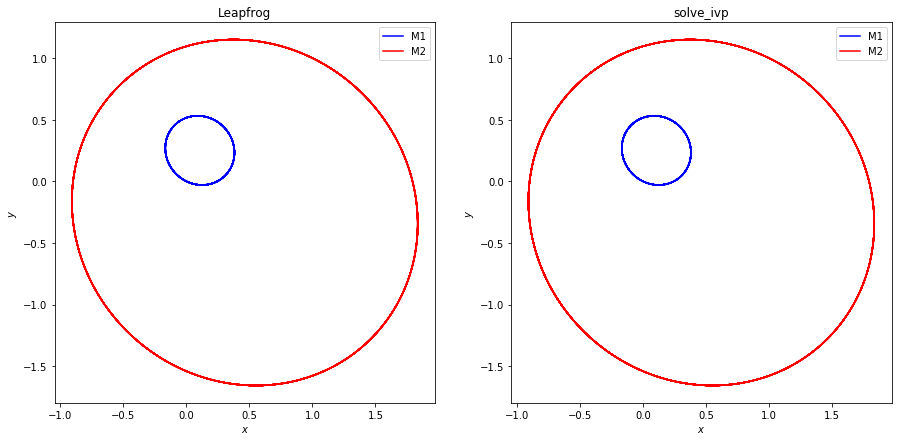

In [7]:
x_vs_y_labels = (r'$x$', r'$y$')
start, stop = start_stop_indices(t_pts, 0., t_end) 

fig = plt.figure(figsize=(15, 7), num='2 body Orbits')
ax_1 = fig.add_subplot(1,2,1)  
ax_2 = fig.add_subplot(1,2,2)

#plots leapfrog orbit
plot_y_vs_x(Lx1com[start : stop], Ly1com[start : stop], 
            axis_labels=x_vs_y_labels, 
            color='blue',
            label='M1',
            title = 'Leapfrog 2-body Orbit',
            ax=ax_1) 
plot_y_vs_x(Lx2com[start : stop], Ly2com[start : stop], 
            axis_labels=x_vs_y_labels, 
            color='red',
            label='M2', 
            ax=ax_1) 

#plots solve_ivp orbit
plot_y_vs_x(x1com[start : stop], y1com[start : stop], 
            axis_labels=x_vs_y_labels, 
            color='blue',
            label='M1',
            title = 'solve_ivp 2-body Orbit',
            ax=ax_2) 
plot_y_vs_x(x2com[start : stop], y2com[start : stop], 
            axis_labels=x_vs_y_labels, 
            color='red',
            label='M2', 
            ax=ax_2) 


This will show that the leapfrog method conserves energy while the solve_ivp function gains energy over time

Now we will do the case where m1>>m2 

In [8]:
#establish inital 2-body parameters and initialize an orbit
m1 = 50.
m2 = 1.
G = 1.

myorbit_largemass = orbits(m1,m2,G)

#create t-pts array
t_start = 0.
t_end = 50.
delta_t = 0.0001

t_pts = np.arange(t_start, t_end+delta_t, delta_t) 

#2 body initial conditions
x1_0=0.
x1dot_0=0.
y1_0=0.
y1dot_0=0.
x2_0=1.
x2dot_0=-2.
y2_0=1.
y2dot_0=1.

#solve ode for 2-body and leapfrog method the LM appended to each variable stands for 'large mass'
x1LM,x1dotLM,y1LM,y1dotLM,x2LM,x2dotLM,y2LM,y2dotLM =\
myorbit_largemass.solve_ode(t_pts, x1_0, x1dot_0,y1_0,y1dot_0, x2_0, x2dot_0, y2_0, y2dot_0)
Lx1LM,Lx1dotLM,Ly1LM,Ly1dotLM,Lx2LM,Lx2dotLM,Ly2LM,Ly2dotLM =\
myorbit_largemass.solve_ode_Leapfrog(t_pts, x1_0, x1dot_0, y1_0,y1dot_0,x2_0, x2dot_0, y2_0, y2dot_0)

In [9]:
#calculate center of momentum then convert to that frame
XcmLM = (m1*x1dotLM+m2*x2dotLM)/(m1+m2)
YcmLM = (m1*y1dotLM+m2*y2dotLM)/(m1+m2)
x1comLM = x1LM-XcmLM*t_pts
x2comLM = x2LM-XcmLM*t_pts
y2comLM = y2LM-YcmLM*t_pts
y1comLM = y1LM-YcmLM*t_pts

#calculate center of momentum and convert for leapfrog method
LXcmLM = (m1*Lx1dotLM+m2*Lx2dotLM)/(m1+m2)
LYcmLM = (m1*Ly1dotLM+m2*Ly2dotLM)/(m1+m2)
Lx1comLM = Lx1LM-LXcmLM*t_pts
Lx2comLM = Lx2LM-LXcmLM*t_pts
Ly2comLM = Ly2LM-LYcmLM*t_pts
Ly1comLM = Ly1LM-LYcmLM*t_pts

(<matplotlib.axes._subplots.AxesSubplot at 0x24aaccedcc0>,
 <matplotlib.lines.Line2D at 0x24aaccc8b00>)

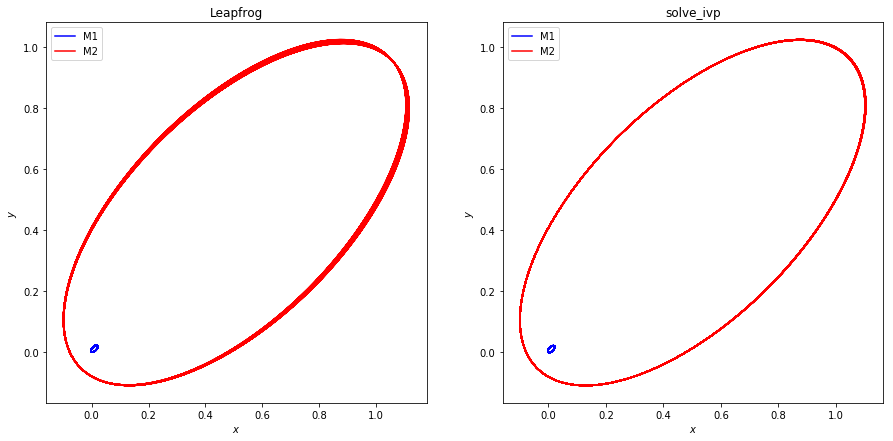

In [10]:
phi_vs_time_labels = (r'$x$', r'$y$')
start, stop = start_stop_indices(t_pts, 0., t_end) 

fig4 = plt.figure(figsize=(15, 7), num='2 body Orbits M1>>M2')
ax_7 = fig4.add_subplot(1,2,1)  
ax_8 = fig4.add_subplot(1,2,2)

#plots leapfrog orbit for m1>>m2
plot_y_vs_x(Lx1comLM[start : stop], Ly1comLM[start : stop], 
            axis_labels=x_vs_y_labels, 
            color='blue',
            label='M1',
            title = 'Leapfrog m1>>m2 2-body Orbit',
            ax=ax_7) 
plot_y_vs_x(Lx2comLM[start : stop], Ly2comLM[start : stop], 
            axis_labels=x_vs_y_labels, 
            color='red',
            label='M2', 
            ax=ax_7) 

#plots solve_ivp orbit m1>>m2
plot_y_vs_x(x1comLM[start : stop], y1comLM[start : stop], 
            axis_labels=x_vs_y_labels, 
            color='blue',
            label='M1',
            title = 'solve_ivp m1>>m2 2-body Orbit',
            ax=ax_8) 
plot_y_vs_x(x2comLM[start : stop], y2comLM[start : stop], 
            axis_labels=x_vs_y_labels, 
            color='red',
            label='M2', 
            ax=ax_8) 

The larger we make the mass the closer the blue orbit (m1) converges to a point which is what we see in class

In [11]:
#Calculate the change in energy for the leapfrog orbit
energyleapfrog = myorbit.energy(t_pts,Lx1,Lx1dot,Ly1,Ly1dot,Lx2,Lx2dot,Ly2,Ly2dot)
eLF_0 = energyleapfrog[0]
eLFrel = np.abs((energyleapfrog-eLF_0)/eLF_0)

#Calculate the change in energy for the solve_ivp orbit
energyivp = myorbit.energy(t_pts,x1,x1dot,y1,y1dot,x2,x2dot,y2,y2dot)
eIVP_0 = energyivp[0]
eIVPrel = np.abs((energyivp-eIVP_0)/eIVP_0)

(<matplotlib.axes._subplots.AxesSubplot at 0x24aaccb6da0>,
 <matplotlib.lines.Line2D at 0x24ab7b4de48>)

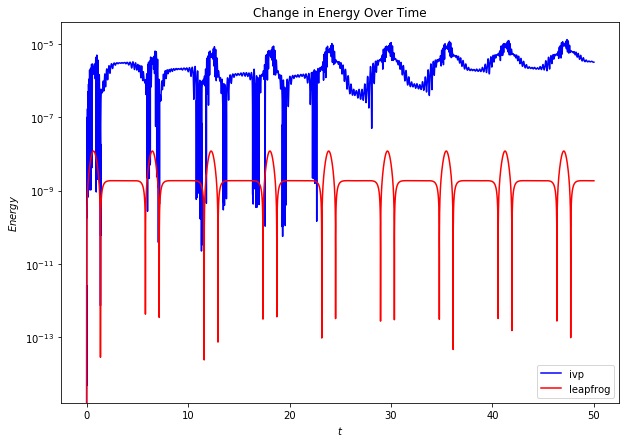

In [12]:
fig = plt.figure(figsize=(10, 7), num='2 body Orbits')
ax_3 =fig.add_subplot(1,1,1) 
E_vs_T_label = (r'$t$', r'$Energy$')
plot_y_vs_x(t_pts[start : stop], eIVPrel[start : stop], 
            axis_labels=E_vs_T_label, 
            color='blue',
            label='ivp',
            title = 'Change in Energy Over Time',
            semilogy=True,
            ax=ax_3) 
plot_y_vs_x(t_pts[start : stop], eLFrel[start : stop], 
            axis_labels=E_vs_T_label, 
            color='red',
            label='leapfrog',
            title = 'Change in Energy Over Time',
            semilogy=True,
            ax=ax_3) 

This plot shows that the energy of the leapfrog method does not increase past a certain value while the solve_ivp one increases.

# 3-Body Orbit

Using the Lagrangian:$L=\frac{G \text{m1} \text{m2}}{\sqrt{(\text{x2}(t)-\text{x1}(t))^2+(\text{y2}(t)-\text{y1}(t))^2}}+\frac{G \text{m1} \text{m3}}{\sqrt{(\text{x3}(t)-\text{x1}(t))^2+(\text{y3}(t)-\text{y1}(t))^2}}+\frac{G \text{m2} \text{m3}}{\sqrt{(\text{x3}(t)-\text{x2}(t))^2+(\text{y3}(t)-\text{y2}(t))^2}}+\frac{1}{2} \text{m1} \left(\text{x1}'(t)^2+\text{y1}'(t)^2\right)+\frac{1}{2} \text{m2} \left(\text{x2}'(t)^2+\text{y2}'(t)^2\right)+\frac{1}{2} \text{m3} \left(\text{x3}'(t)^2+\text{y3}'(t)^2\right)$
 
 We solve for:$\text{x1}''(t)\to -G \left(\frac{\text{m2} (\text{x1}(t)-\text{x2}(t))}{\left((\text{x1}(t)-\text{x2}(t))^2+(\text{y1}(t)-\text{y2}(t))^2\right)^{3/2}}+\frac{\text{m3} (\text{x1}(t)-\text{x3}(t))}{\left((\text{x1}(t)-\text{x3}(t))^2+(\text{y1}(t)-\text{y3}(t))^2\right)^{3/2}}\right),\text{x2}''(t)\to -G \left(\frac{\text{m1} (\text{x2}(t)-\text{x1}(t))}{\left((\text{x1}(t)-\text{x2}(t))^2+(\text{y1}(t)-\text{y2}(t))^2\right)^{3/2}}+\frac{\text{m3} (\text{x2}(t)-\text{x3}(t))}{\left((\text{x2}(t)-\text{x3}(t))^2+(\text{y2}(t)-\text{y3}(t))^2\right)^{3/2}}\right),
 \text{x3}''(t)\to -G \left(\frac{\text{m1} (\text{x3}(t)-\text{x1}(t))}{\left((\text{x1}(t)-\text{x3}(t))^2+(\text{y1}(t)-\text{y3}(t))^2\right)^{3/2}}+\frac{\text{m2} (\text{x3}(t)-\text{x2}(t))}{\left((\text{x2}(t)-\text{x3}(t))^2+(\text{y2}(t)-\text{y3}(t))^2\right)^{3/2}}\right),$ 
 $\text{y1}''(t)\to -G \left(\frac{\text{m2} (\text{y1}(t)-\text{y2}(t))}{\left((\text{x1}(t)-\text{x2}(t))^2+(\text{y1}(t)-\text{y2}(t))^2\right)^{3/2}}+\frac{\text{m3} (\text{y1}(t)-\text{y3}(t))}{\left((\text{x1}(t)-\text{x3}(t))^2+(\text{y1}(t)-\text{y3}(t))^2\right)^{3/2}}\right),\text{y2}''(t)\to -G \left(\frac{\text{m1} (\text{y2}(t)-\text{y1}(t))}{\left((\text{x1}(t)-\text{x2}(t))^2+(\text{y1}(t)-\text{y2}(t))^2\right)^{3/2}}+\frac{\text{m3} (\text{y2}(t)-\text{y3}(t))}{\left((\text{x2}(t)-\text{x3}(t))^2+(\text{y2}(t)-\text{y3}(t))^2\right)^{3/2}}\right),\text{y3}''(t)\to -G \left(\frac{\text{m1} (\text{y3}(t)-\text{y1}(t))}{\left((\text{x1}(t)-\text{x3}(t))^2+(\text{y1}(t)-\text{y3}(t))^2\right)^{3/2}}+\frac{\text{m2} (\text{y3}(t)-\text{y2}(t))}{\left((\text{x2}(t)-\text{x3}(t))^2+(\text{y2}(t)-\text{y3}(t))^2\right)^{3/2}}\right)$
 which we pass to solve_ivp and the leapfrog solver.


In [13]:
class orbits3():
    def __init__(self,m1,m2,m3,G):
        """
        G = gravitational constant
        m1 = mass of body 1
        m2 = mass of body 2
        m3 = mass of body 3
        
        """
        self.G=G
        self.m1 = m1
        self.m2 = m2
        self.m3 = m3
        
    def dy_dt(self,t,y):
        """
        x1=x position of body 1
        x2=x position of body 2
        x3=x position of body 3
        y1=y position of body 1
        y2=y position of body 2
        y3=y position of body 3
        
        
        Parameters
        ----------
        t : float
            time 
        y : float
            A 12-component vector with y[0]=x1[t],y[1]=dx1/dt[t],y[2]=y1[t],
            y[3]=dy1/dt[t],y[4]=x2[t],y[5]=dx2/dt[t],y[6]=y2[t],y[7]=dy2/dt[t],
            y[8]=x3[t],y[9]=dx3/dt[t],y[10]=y3[t],y[11]=dy3/dt[t]
            
        Returns
        -------
        This function returns the right-hand side of the diffeq: 
        [dx1/dt d^2x1/dt^2 dy1/dt d^2y1/dt^2 dx2/dt d^2x2/dt^2 dy2/dt 
        d^2y2/dt^2 dx3/dt d^2x3/dt^2 dy3/dt d^2y3/dt^2 ]
        """
        G=self.G
        m1=self.m1
        m2=self.m2
        m3=self.m3
        x1,x1dot,y1,y1dot,x2,x2dot,y2,y2dot,x3,x3dot,y3,y3dot = y
        
        
        x1ddot = -G*m2*(x1-x2)/((x1-x2)**2.+(y1-y2)**2.)**(3./2.)\
        -G*m3*(x1-x3)/((x1-x3)**2.+(y1-y3)**2.)**(3./2.)
        
        x2ddot = -G*m1*(x2-x1)/((x1-x2)**2.+(y1-y2)**2.)**(3./2.)\
        -G*m3*(x2-x3)/((x2-x3)**2.+(y2-y3)**2.)**(3./2.)
        
        x3ddot = -G*m1*(x3-x1)/((x1-x3)**2.+(y1-y3)**2.)**(3./2.)\
        -G*m2*(x3-x2)/((x2-x3)**2.+(y2-y3)**2.)**(3./2.)
        
        y1ddot = -G*m2*(y1-y2)/((x1-x2)**2.+(y1-y2)**2.)**(3./2.)\
        -G*m3*(y1-y3)/((x1-x3)**2.+(y1-y3)**2.)**(3./2.)
        
        y2ddot = -G*m1*(y2-y1)/((x1-x2)**2.+(y1-y2)**2.)**(3./2.)\
        -G*m3*(y2-y3)/((x2-x3)**2.+(y2-y3)**2.)**(3./2.)
        
        y3ddot = -G*m1*(y3-y1)/((x1-x3)**2.+(y1-y3)**2.)**(3./2.)\
        -G*m2*(y3-y2)/((x2-x3)**2.+(y2-y3)**2.)**(3./2.)
            

        return x1dot,x1ddot,y1dot,y1ddot,x2dot,x2ddot,y2dot,y2ddot,x3dot,x3ddot,y3dot,y3ddot

                                                                                            
    def solve_ode(self, t_pts, y_0,
                  abserr=1.0e-8, relerr=1.0e-6):
        """
        Solve the ODE given initial conditions.
        For now use odeint, but we have the option to switch.
        Specify smaller abserr and relerr to get more precision.
        """
        
        solution = solve_ivp(self.dy_dt, (t_pts[0], t_pts[-1]), 
                             y_0, t_eval=t_pts, 
                             atol=abserr, rtol=relerr)

        return solution.y

    
    def solve_ode_Leapfrog(self, t_pts, y_0):
        """
        Solve the ODE given initial conditions with the Leapfrog method.
        """
        delta_t = t_pts[1] - t_pts[0]
        
        # initialize the arrays for r, rdot, r_dot_half, phi with zeros
        num_t_pts = len(t_pts)
        x1 = np.zeros(num_t_pts)
        x1dot = np.zeros(num_t_pts)
        x1_dot_half = np.zeros(num_t_pts)
        
        x2 = np.zeros(num_t_pts)
        x2dot = np.zeros(num_t_pts)
        x2_dot_half = np.zeros(num_t_pts)
        
        x3 = np.zeros(num_t_pts)
        x3dot = np.zeros(num_t_pts)
        x3_dot_half = np.zeros(num_t_pts)
        
        y1 = np.zeros(num_t_pts)
        y1dot = np.zeros(num_t_pts)
        y1_dot_half = np.zeros(num_t_pts)
        
        y2 = np.zeros(num_t_pts)
        y2dot = np.zeros(num_t_pts)
        y2_dot_half = np.zeros(num_t_pts)
        
        y3 = np.zeros(num_t_pts)
        y3dot = np.zeros(num_t_pts)
        y3_dot_half = np.zeros(num_t_pts)
        
        x1[0],x1dot[0],y1[0],y1dot[0],x2[0],x2dot[0],y2[0],y2dot[0],x3[0],x3dot[0],y3[0],y3dot[0] = y_0
        
        
        # step through the differential equation
        for i in np.arange(num_t_pts - 1):
            t = t_pts[i]
            
            y = [x1[i],x1dot[i],y1[i],y1dot[i],x2[i],x2dot[i],y2[i],y2dot[i],\
                 x3[i],x3dot[i],y3[i],y3dot[i]]
            
            x1_dot_half[i] = x1dot[i] + self.dy_dt(t, y)[1] * delta_t/2.
            x1[i+1] = x1[i] + x1_dot_half[i] * delta_t
            
            x2_dot_half[i] = x2dot[i] + self.dy_dt(t, y)[5] * delta_t/2.
            x2[i+1] = x2[i] + x2_dot_half[i] * delta_t
            
            x3_dot_half[i] = x3dot[i] + self.dy_dt(t, y)[9] * delta_t/2.
            x3[i+1] = x3[i] + x3_dot_half[i] * delta_t
            
            y1_dot_half[i] = y1dot[i] + self.dy_dt(t, y)[3] * delta_t/2.
            y1[i+1] = y1[i] + y1_dot_half[i] * delta_t
            
            y2_dot_half[i] = y2dot[i] + self.dy_dt(t, y)[7] * delta_t/2.
            y2[i+1] = y2[i] + y2_dot_half[i] * delta_t
            
            y3_dot_half[i] = y3dot[i] + self.dy_dt(t, y)[11] * delta_t/2.
            y3[i+1] = y3[i] + y3_dot_half[i] * delta_t
            
            
            #update the coords
            y = [x1[i+1],x1dot[i],y1[i+1],y1dot[i],x2[i+1],x2dot[i],y2[i+1],\
                 y2dot[i],x3[i+1],x3dot[i],y3[i+1],y3dot[i]]
            
            x1dot[i+1] = x1_dot_half[i] + self.dy_dt(t, y)[1] * delta_t/2.
            x2dot[i+1] = x2_dot_half[i] + self.dy_dt(t, y)[5] * delta_t/2.
            x3dot[i+1] = x3_dot_half[i] + self.dy_dt(t, y)[9] * delta_t/2.
            y1dot[i+1] = y1_dot_half[i] + self.dy_dt(t, y)[3] * delta_t/2.
            y2dot[i+1] = y2_dot_half[i] + self.dy_dt(t, y)[7] * delta_t/2.
            y3dot[i+1] = y3_dot_half[i] + self.dy_dt(t, y)[11] * delta_t/2.
            
            
            
                
        return x1,x1dot,y1,y1dot,x2,x2dot,y2,y2dot,x3,x3dot,y3,y3dot

    def energy(self, t_pts, x1,x1dot,y1,y1dot,x2,x2dot,y2,y2dot,x3,x3dot,y3,y3dot):
        """Evaluate the energy as a function of time"""
        m1 = self.m1
        m2 = self.m2
        G = self.G
        energy = (1./2.)*m1*(x1dot**2.+y1dot**2.)+(1./2.)*m2*(x2dot**2.+y2dot**2.)+(1./2.)*m3*(x3dot**2.+y3dot**2.)\
            -G*m1*m2/np.sqrt((x2-x1)**2.+(y2-y1)**2.)-G*m1*m3/np.sqrt((x3-x1)**2.+(y3-y1)**2.)-G*m3*m2/np.sqrt((x2-x3)\
            **2.+(y2-y3)**2.)
            
        return energy
    

In [14]:
#establish inital 3-body parameters and initialize an orbit
m1 = 5.
m2 = 5.
m3 = 5.
G = 2.

myorbit3 = orbits3(m1=m1,m2=m2,m3=m3,G=G)

#create t-pts array
t_start = 0.
t_end = 70.
delta_t = 0.001

t_pts = np.arange(t_start, t_end+delta_t, delta_t) 

#3 body initial conditions
x1_0,y1_0 = 0. ,5.
x1dot_0,y1dot_0 = -1,0

x2_0,y2_0 = -5.*np.sqrt(3.)/2.,-2.5
x2dot_0,y2dot_0 = .5,-np.sqrt(3.)/2.

x3_0,y3_0 = 5.*np.sqrt(3.)/2.,-2.5
x3dot_0,y3dot_0 = .5,np.sqrt(3.)/2.
y_0 = x1_0, x1dot_0, y1_0,y1dot_0, x2_0, x2dot_0, y2_0, y2dot_0, x3_0, x3dot_0, y3_0, y3dot_0

#solve ode for 3-body and leapfrog method
Tx1,Tx1dot,Ty1,Ty1dot,Tx2,Tx2dot,Ty2,Ty2dot,Tx3,Tx3dot,Ty3,Ty3dot \
= myorbit3.solve_ode(t_pts, y_0)

TLx1,TLx1dot,TLy1,TLy1dot,TLx2,TLx2dot,TLy2,TLy2dot,TLx3,TLx3dot,TLy3,TLy3dot \
= myorbit3.solve_ode_Leapfrog(t_pts, y_0)

In [15]:
#calculate center of momentum then convert to that frame
TXcm = (m1*Tx1dot+m2*Tx2dot+m3*Tx3dot)/(m1+m2+m3) #X center of momentum
TYcm = (m1*Ty1dot+m2*Ty2dot+m3*Ty3dot)/(m1+m2+m3) #Y center of momentum
#Center of mass corrected coordinates:
Tx1com = Tx1-TXcm*t_pts
Tx2com = Tx2-TXcm*t_pts
Tx3com = Tx3-TXcm*t_pts
Ty2com = Ty2-TYcm*t_pts
Ty1com = Ty1-TYcm*t_pts
Ty3com = Ty3-TYcm*t_pts

#calculate center of momentum and convert for leapfrog method
TLXcm = (m1*TLx1dot+m2*TLx2dot+m3*TLx3dot)/(m1+m2+m3)
TLYcm = (m1*TLy1dot+m2*TLy2dot+m3*TLy3dot)/(m1+m2+m3)
TLx1com = TLx1-TLXcm*t_pts
TLx2com = TLx2-TLXcm*t_pts
TLx3com = TLx3-TLXcm*t_pts
TLy2com = TLy2-TLYcm*t_pts
TLy1com = TLy1-TLYcm*t_pts
TLy3com = TLy3-TLYcm*t_pts


(<matplotlib.axes._subplots.AxesSubplot at 0x24abfde86d8>,
 <matplotlib.lines.Line2D at 0x24abfe85ba8>)

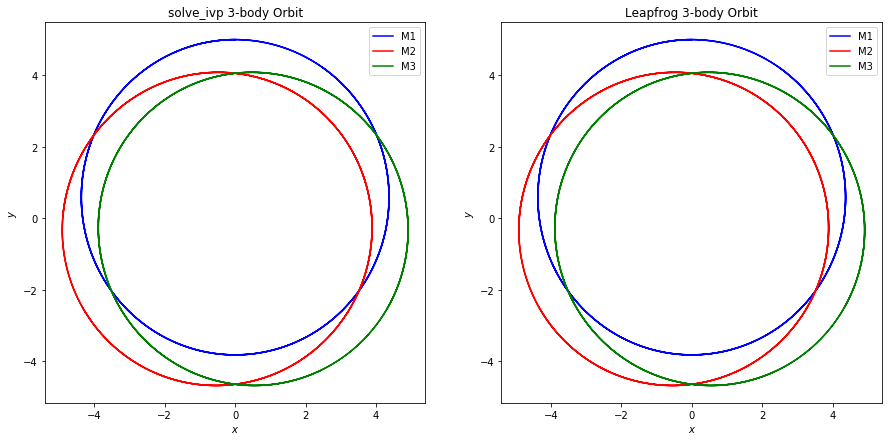

In [16]:
#Plot the 3-body orbit
fig = plt.figure(figsize=(15, 7), num='2 body Orbits')
ax_4 = fig.add_subplot(1,2,1)  
ax_5 = fig.add_subplot(1,2,2)
start, stop = start_stop_indices(t_pts, 0., t_end) 

plot_y_vs_x(Tx1com[start : stop], Ty1com[start : stop], 
            axis_labels=x_vs_y_labels, 
            color='blue',
            label='M1',
            ax=ax_4) 
plot_y_vs_x(Tx2com[start : stop], Ty2com[start : stop], 
            axis_labels=x_vs_y_labels, 
            color='red',
            label='M2', 
            ax=ax_4) 
plot_y_vs_x(Tx3com[start : stop], Ty3com[start : stop], 
            axis_labels=x_vs_y_labels, 
            color='green',
            label='M3', 
            title='solve_ivp 3-body Orbit',
            ax=ax_4) 

plot_y_vs_x(TLx1com[start : stop], TLy1com[start : stop], 
            axis_labels=x_vs_y_labels, 
            color='blue',
            label='M1',
            ax=ax_5) 
plot_y_vs_x(TLx2com[start : stop], TLy2com[start : stop], 
            axis_labels=x_vs_y_labels, 
            color='red',
            label='M2', 
            title='Leapfrog 3-body Orbit',
            ax=ax_5) 
plot_y_vs_x(TLx3com[start : stop], TLy3com[start : stop], 
            axis_labels=x_vs_y_labels, 
            color='green',
            label='M3', 
            ax=ax_5) 

This orbit is interesting in that it appears stable for small time values but for larger time values (like 300), the masses start spiraling away. The likely cause is that the ode solver becomes more innacurate for large time values.

In [17]:
#Calculate the change in energy of both diff eq solutions
Tenergyleapfrog = myorbit3.energy(t_pts,TLx1,TLx1dot,TLy1,TLy1dot,TLx2,TLx2dot,TLy2,TLy2dot,TLx3,TLx3dot,TLy3,TLy3dot)
TeLF_0 = Tenergyleapfrog[0]
TeLFrel = np.abs((Tenergyleapfrog-TeLF_0)/TeLF_0)

Tenergyivp = myorbit3.energy(t_pts,Tx1,Tx1dot,Ty1,Ty1dot,Tx2,Tx2dot,Ty2,Ty2dot,Tx3,Tx3dot,Ty3,Ty3dot)
TeIVP_0 = Tenergyivp[0]
TeIVPrel = np.abs((Tenergyivp-TeIVP_0)/TeIVP_0)

(<matplotlib.axes._subplots.AxesSubplot at 0x24ac285a630>,
 <matplotlib.lines.Line2D at 0x24ab203a5c0>)

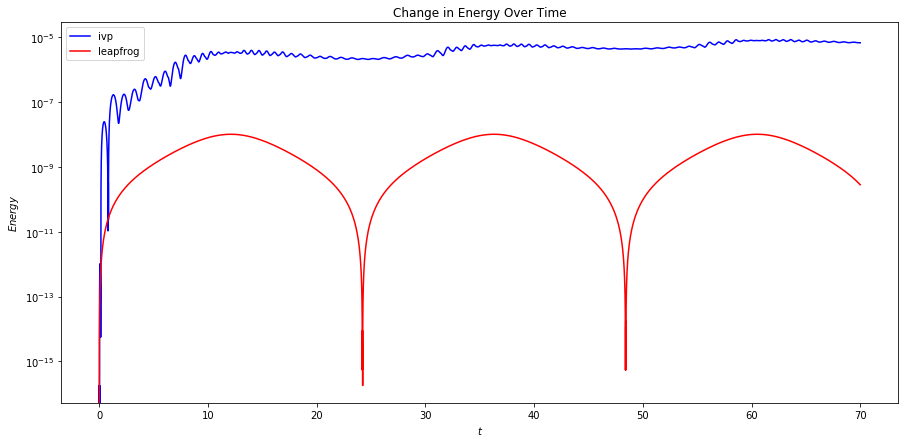

In [18]:
#Plot change in energy
fig = plt.figure(figsize=(15, 7), num='2 body Orbits')
ax_4 =fig.add_subplot(1,1,1) 
E_vs_T_label = (r'$t$', r'$Energy$')
plot_y_vs_x(t_pts[start : stop], TeIVPrel[start : stop], 
            axis_labels=E_vs_T_label, 
            color='blue',
            label='ivp',
            title = 'Change in Energy Over Time',
            semilogy=True,
            ax=ax_4) 
plot_y_vs_x(t_pts[start : stop], TeLFrel[start : stop], 
            axis_labels=E_vs_T_label, 
            color='red',
            label='leapfrog',
            title = 'Change in Energy Over Time',
            semilogy=True,
            ax=ax_4) 

The leapfrog method energy does not increase past a certain value while the solve_ivp method continues to increase as time increases.

Traceback (most recent call last):
  File "C:\Users\Ben\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py", line 387, in process
    proxy(*args, **kwargs)
  File "C:\Users\Ben\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py", line 227, in __call__
    return mtd(*args, **kwargs)
  File "C:\Users\Ben\Anaconda3\lib\site-packages\matplotlib\animation.py", line 1499, in _stop
    self.event_source.remove_callback(self._loop_delay)
AttributeError: 'NoneType' object has no attribute 'remove_callback'


<IPython.core.display.Javascript object>


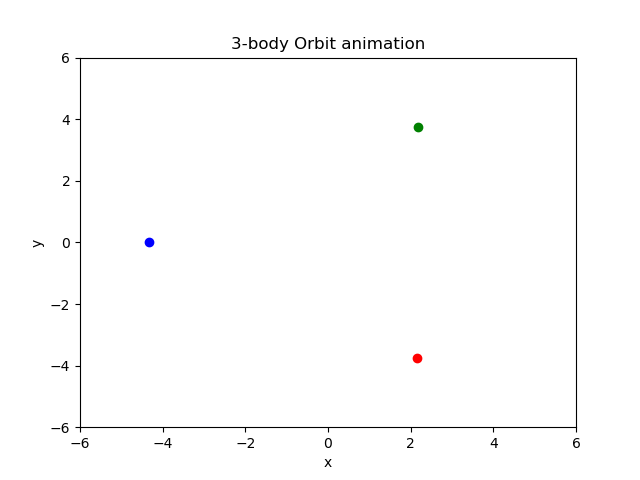

In [22]:
#The colors of the masses correspond to the color of the orbits above
%matplotlib nbagg


fig, ax = plt.subplots()
ax = plt.axis([-6,6,-6,6])
plt.title("3-body Orbit animation")
plt.xlabel('x')
plt.ylabel('y')

#set initial positions of masses
mass1, = plt.plot(Tx1com[0], Ty1com[0], 'bo')
mass2, = plt.plot(Tx2com[0], Ty2com[0], 'ro')
mass3, = plt.plot(Tx3com[0], Ty3com[0], 'go')

#this function updates the position of each mass
def animate(i):
    mass1.set_data(Tx1com[i], Ty1com[i])
    mass2.set_data(Tx2com[i],Ty2com[i])
    mass3.set_data(Tx3com[i],Ty3com[i])

# create animation using the animate() function, each time step is equal to a step of delta_t 
myAnimation = animation.FuncAnimation(fig, animate, frames=np.arange(0,len(Tx1com), 1), \
                                      interval=3, blit=True, repeat=True)

plt.show()

If the animation doesnt work when you run all cells then try shift-entering the animation cell again. The animation itself can also be a bit laggy.